# 2.5 DC Resisitivy inversion

In [1]:
import pathlib

import discretize
import matplotlib.pyplot as plt
import numpy as np
import pooch
import simpeg
from matplotlib.colors import LogNorm
from simpeg.electromagnetics.static import resistivity as dc

import inversion_ideas as ii

## Load data

In [2]:
url = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/inv_dcr_2d_files.tar.gz"

fnames = pooch.retrieve(url, known_hash=None, processor=pooch.Untar())
fnames = [pathlib.Path(f) for f in fnames]
fnames

[PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/topo_2d.txt'),
 PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/dc_data.obs')]

In [3]:
(topo_fname,) = [f for f in fnames if "topo_2d.txt" in f.name]
(data_fname,) = [f for f in fnames if "dc_data.obs" in f.name]
topo_fname, data_fname

(PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/topo_2d.txt'),
 PosixPath('/home/santi/.cache/pooch/a567d6514bf50ed948b5d7b7e4125664-inv_dcr_2d_files.tar.gz.untar/inv_dcr_2d_files/dc_data.obs'))

In [4]:
# Load 2D topography
topo_2d = np.loadtxt(str(topo_fname))

In [5]:
voltage_data = simpeg.utils.io_utils.read_dcip2d_ubc(data_fname, "volt", "general")

In [6]:
# Apply uncertainties to normalized voltage data
voltage_data.standard_deviation = 1e-7 + 0.05 * np.abs(voltage_data.dobs)

In [7]:
# Get apparent conductivities from volts and survey geometry
apparent_resistivities = (
    simpeg.electromagnetics.static.utils.static_utils.apparent_resistivity_from_voltage(
        voltage_data.survey, voltage_data.dobs
    )
)

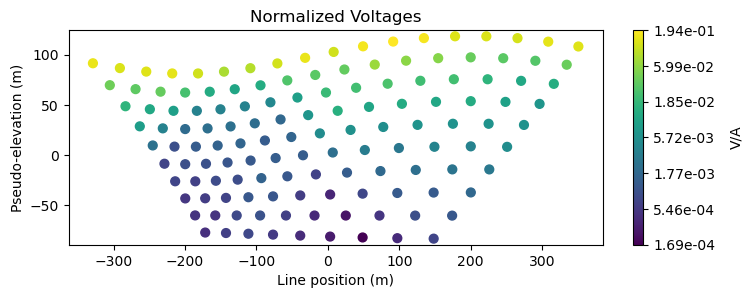

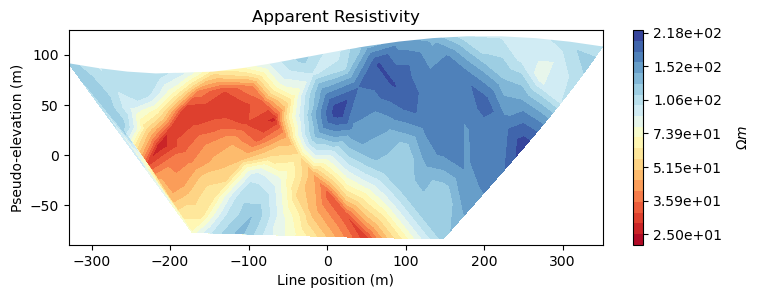

In [8]:
from simpeg.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": "viridis"},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(
    voltage_data.survey, voltage_data.dobs
)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label=r"$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": "RdYlBu"},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Create mesh

In [9]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = discretize.TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, topo_2d[:, -1].max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = voltage_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

In [10]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = discretize.utils.active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

In [11]:
# Project electrodes to topography
voltage_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define simulation

In [12]:
# Map model parameters to all cells.
# We'll use log conductivities as model, so we need to pass an ExpMap
# to the simulation in order to convert log conductivities to conductivities.
log_conductivity_map = simpeg.maps.InjectActiveCells(
    mesh, active_cells, 1e-8
) * simpeg.maps.ExpMap(nP=n_active)

In [13]:
# Get median apparent resistivity
median_resistivity = np.median(apparent_resistivities)
median_conductivity = 1 / median_resistivity

# TODO: this is not the median conduct, right?
# Shall we do median_conductivity = np.median(1 / apparent_resistivities)?

# Create initial model (log conductivity)
initial_model = np.log(1 / median_resistivity) * np.ones(n_active)

In [14]:
solver = simpeg.utils.solver_utils.get_default_solver()
simulation_simpeg = dc.simulation_2d.Simulation2DNodal(
    mesh,
    survey=voltage_data.survey,
    sigmaMap=log_conductivity_map,
    storeJ=True,
    solver=solver,
)

## Create inversion

Wrap the simulation into an object that can be used in the new framework

In [15]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)
simulation

Extract data and uncertainties from data object and build the data misfit

In [16]:
data = voltage_data.dobs
uncertainties = voltage_data.standard_deviation

data_misfit = ii.DataMisfit(data, uncertainties, simulation)

Define regularization (smallness) with sensitivity weights

In [17]:
# Get sensitivity weights
volumes = mesh.cell_volumes[active_cells]
sensitivity_weights = ii.utils.get_sensitivity_weights(
    simulation.jacobian(initial_model),
    data_weights=data_misfit.weights_matrix,
    volumes=volumes,
    vmin=0.01,
)
weights_dict = {
    "sensitivity": sensitivity_weights,
}

# Use the initial model as our reference model
reference_model = initial_model.copy()

alpha_s = 0.06
smallness = ii.Smallness(
    mesh=mesh,
    active_cells=active_cells,
    cell_weights=weights_dict,
    reference_model=initial_model,
)
smoothness_x, smoothness_y = tuple(
    ii.Flatness(
        mesh=mesh,
        active_cells=active_cells,
        direction=direction,
        cell_weights=weights_dict,
    )
    for direction in ("x", "y")
)

model_norm = (alpha_s * smallness + smoothness_x + smoothness_y).flatten()
model_norm

/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:768: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:795: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]
/home/santi/.miniforge3/envs/inversion_ideas/lib/python3.13/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


0.06 φs(m) + φx(m) + φy(m)

Build inversion

In [18]:
beta_0 = 5
regularization = beta_0 * model_norm
phi = data_misfit + regularization

# Gauss-Newton CG minimizer
minimizer = ii.GaussNewtonConjugateGradient(maxiter=2, rtol=0.01)

# Use a Jacobi preconditioner
preconditioner = ii.JacobiPreconditioner(phi)
minimizer_kwargs = {"preconditioner": preconditioner}

# Stopping criteria
chi_target = 1.0
stopping_criteria = ii.ChiTarget(data_misfit, chi_target=chi_target)

# Directives
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)
update_sens_weights = ii.UpdateSensitivityWeights(
    regularization,
    simulation=simulation,
    data_weights=data_misfit.weights_matrix,
    volumes=mesh.cell_volumes[active_cells],
    vmin=0.01,
)
directives = [beta_cooler, update_sens_weights]

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=directives,
    stopping_criteria=stopping_criteria,
    cache_models=True,
    minimizer_kwargs=minimizer_kwargs,
)

## Run the inversion

In [19]:
inverted_model = inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [20]:
for minimizer_log in inversion.log.minimizer_logs:
    if minimizer_log is not None:
        minimizer_log.show()

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┓
┃ iteration ┃ model                       ┃ objective_value ┃ conj_grad_iters ┃ line_search_iters ┃ step_norm ┃   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━┩
│ 0         │ [-4.58151669 -4.58151669    │ 4.45e+04        │ 0               │ 0                 │ 0         │   │
│           │ -4.58151669 ... -4.58151669 │                 │                 │                   │           │   │
│           │ -4.58151669                 │                 │                 │                   │           │   │
│           │  -4.58151669]               │                 │                 │                   │           │   │
│ 1         │ [-4.5815244  -4.58152295    │ 4.45e+04        │ 0               │ 1                 │ 1.42e+01  │ 0 │
│           │ -4.58153199 ... -4.5815263  │                 │                 │                   │           │   │
│           │ -4.58154021                 │                 │                 │                   │           │   │
│           │  -4.58185369]               │                 │                 │                   │           │   │
│ 2         │ [-4.58152553 -4.58152388    │ 1.27e+04        │ 0               │ 1                 │ 8.19e+00  │ 0 │
│           │ -4.58153433 ... -4.58152755 │                 │                 │                   │           │   │
│           │ -4.58154342                 │                 │                 │                   │           │   │
│           │  -4.58189799]               │                 │                 │                   │           │   │
└───────────┴─────────────────────────────┴─────────────────┴─────────────────┴───────────────────┴───────────┴───┘

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┓
┃ iteration ┃ model                       ┃ objective_value ┃ conj_grad_iters ┃ line_search_iters ┃ step_norm ┃   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━┩
│ 0         │ [-4.58152553 -4.58152388    │ 3.86e+03        │ 0               │ 0                 │ 0         │   │
│           │ -4.58153433 ... -4.58152755 │                 │                 │                   │           │   │
│           │ -4.58154342                 │                 │                 │                   │           │   │
│           │  -4.58189799]               │                 │                 │                   │           │   │
│ 1         │ [-4.58152557 -4.5815239     │ 3.86e+03        │ 0               │ 1                 │ 5.70e+00  │ 0 │
│           │ -4.58153457 ... -4.5815272  │                 │                 │                   │           │   │
│           │ -4.58154266                 │                 │                 │                   │           │   │
│           │  -4.58188797]               │                 │                 │                   │           │   │
│ 2         │ [-4.58152614 -4.58152436    │ 1.32e+03        │ 0               │ 1                 │ 3.53e+00  │ 0 │
│           │ -4.5815355  ... -4.58152848 │                 │                 │                   │           │   │
│           │ -4.58154566                 │                 │                 │                   │           │   │
│           │  -4.58192929]               │                 │                 │                   │           │   │
└───────────┴─────────────────────────────┴─────────────────┴─────────────────┴───────────────────┴───────────┴───┘

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┓
┃ iteration ┃ model                       ┃ objective_value ┃ conj_grad_iters ┃ line_search_iters ┃ step_norm ┃   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━┩
│ 0         │ [-4.58152614 -4.58152436    │ 4.99e+02        │ 0               │ 0                 │ 0         │   │
│           │ -4.5815355  ... -4.58152848 │                 │                 │                   │           │   │
│           │ -4.58154566                 │                 │                 │                   │           │   │
│           │  -4.58192929]               │                 │                 │                   │           │   │
│ 1         │ [-4.58152756 -4.58152543    │ 4.99e+02        │ 0               │ 1                 │ 2.89e+00  │ 0 │
│           │ -4.58153819 ... -4.58153061 │                 │                 │                   │           │   │
│           │ -4.58155102                 │                 │                 │                   │           │   │
│           │  -4.58200435]               │                 │                 │                   │           │   │
│ 2         │ [-4.58152851 -4.58152616    │ 2.90e+02        │ 0               │ 1                 │ 1.54e+00  │ 0 │
│           │ -4.58153993 ... -4.58153216 │                 │                 │                   │           │   │
│           │ -4.58155483                 │                 │                 │                   │           │   │
│           │  -4.58205792]               │                 │                 │                   │           │   │
└───────────┴─────────────────────────────┴─────────────────┴─────────────────┴───────────────────┴───────────┴───┘

In [21]:
inverted_conductivity = np.exp(inverted_model)

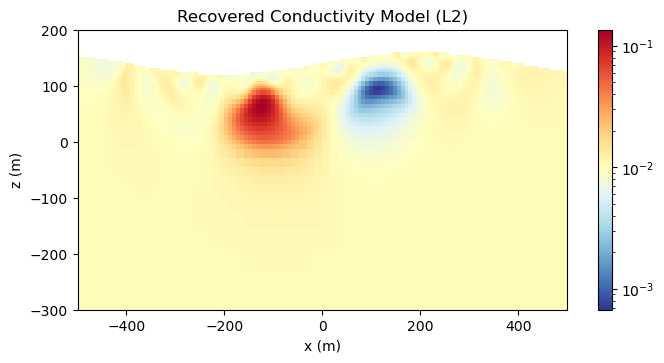

In [22]:
norm = LogNorm()
plotting_map = simpeg.maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
(tmp,) = mesh.plot_image(
    plotting_map * inverted_conductivity,
    normal="Y",
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": "RdYlBu_r"},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Recovered Conductivity Model (L2)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

# ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="vertical", cmap="RdYlBu_r"
# )
plt.colorbar(tmp, ax=ax1, norm=norm, orientation="vertical")
# cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

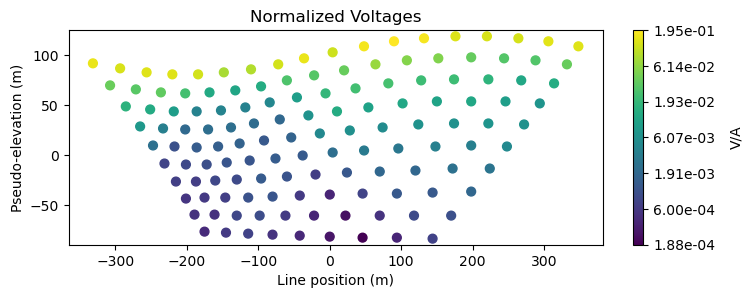

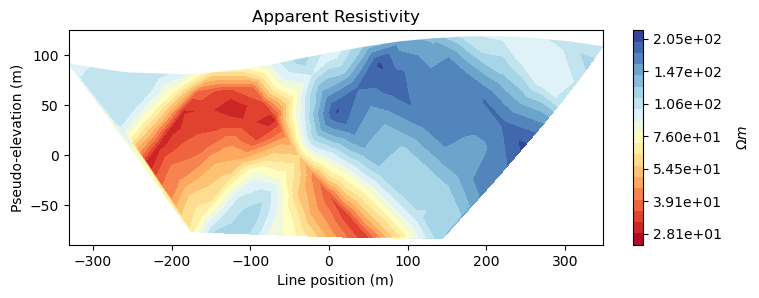

In [23]:
dpred = simulation(inverted_model)


prediction = simpeg.Data(voltage_data.survey, dobs=dpred)

# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    prediction,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": "viridis"},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(voltage_data.survey, dpred)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label=r"$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": "RdYlBu"},
)
ax1.set_title("Apparent Resistivity")
plt.show()

In [24]:
# Sensitivity weights were updated
for reg in (smallness, smoothness_x, smoothness_y):
    assert reg.cell_weights["sensitivity"] is not sensitivity_weights